This file generates plots for fairness metrics in machine learning models trained with Stochastic Ghost. It provides a convenient tool for visualizing various fairness measures, such as disparate impact, equal opportunity, and predictive parity or anything specific according to the use case, to assess the performance and fairness of models across different demographic groups.

In [ ]:
import os
from sklearn.metrics import roc_curve, auc, log_loss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from torch.utils.data import TensorDataset
from torcheval.metrics.functional import binary_accuracy ,binary_auroc, binary_confusion_matrix
from src.experiments.utils.load_folktables import load_folktables_torch
from src.algorithms.c_utils.constraint_fns import *
from fairret.loss import NormLoss
from fairret.statistic import *

### **Preparation**

**Load the Folktables dataset for the selected state and prepare it for usage**

In [3]:
TASK = 'income'
# TASK = 'employment'
STATE = 'OK'

In [4]:
X_train, y_train, [w_idx_train, nw_idx_train], X_test, y_test, [w_idx_test, nw_idx_test] = load_folktables_torch(
        TASK, state=STATE, random_state=42, make_unbalanced = False, onehot=False
    )

sensitive_value_0 = 'white'
sensitive_value_1 = 'non-white'

In [5]:
device = 'cuda' if torch.cuda.is_available() and False else 'cpu'

In [6]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)
    
X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)
    
X_train_w = X_train_tensor[w_idx_train]
y_train_w = y_train_tensor[w_idx_train]
X_train_nw = X_train_tensor[nw_idx_train]
y_train_nw = y_train_tensor[nw_idx_train]
    
X_test_w = X_test_tensor[w_idx_test]
y_test_w = y_test_tensor[w_idx_test]
X_test_nw = X_test_tensor[nw_idx_test]
y_test_nw = y_test_tensor[nw_idx_test]

In [7]:
print('w, nw, total')
print('train')
print(len(y_train_w), len(y_train_nw), len(y_train))
print(sum(y_train_w == 1)/len(y_train_w), sum(y_train_nw == 1)/len(y_train_nw), sum(y_train_tensor == 1)/len(y_train_tensor))
print('test')
print(len(y_test_w), len(y_test_nw), len(y_test))
print(sum(y_test_w == 1)/len(y_test_w), sum(y_test_nw == 1)/len(y_test_nw), sum(y_test_tensor == 1)/len(y_test_tensor))

w, nw, total
train
10680 3653 14333
tensor(0.3081) tensor(0.2078) tensor(0.2825)
test
2670 914 3584
tensor(0.3075) tensor(0.2068) tensor(0.2818)


In [8]:
loaded_models = []

**Load saved models**

In [9]:
# LOSS_BOUND = 0.05
LOSS_BOUND = 0.005
DATASET = TASK + '_' + STATE
# constraint = 'fpr'
constraint = 'loss'
DIRECTORY_PATH = "./src/experiments/utils/saved_models/" + DATASET + '/'+ constraint + '/' + f'{LOSS_BOUND:.0e}' + '/'
FILE_EXT = '.pt'

In [10]:
class SimpleNet(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_shape),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [11]:
directory_path = DIRECTORY_PATH
file_list = os.listdir(directory_path)
model_files = [file for file in file_list if file.endswith(FILE_EXT)]
for model_file in model_files:
    # if model_file.startswith('sg_a'):
    #     continue
    model_name = model_file
    model = SimpleNet(X_test.shape[1], 1).to(device)
    print(model_file, end='\r')
    try:
        model.load_state_dict(torch.load(directory_path + model_name, weights_only=False, map_location=device))
    except:
        continue
    model_file = str.join('', model_file.split('_trial')[:-1])
    loaded_models.append((model_file, model))

In [33]:
sum([len(p) for p in list(model.parameters())])

194

In [12]:
def get_alg_name(alg:str):
    if alg.startswith('swsg'):
        return 'Switching Subgradient'
    elif alg.startswith('sgd'):
        return 'SGD'
    elif alg.startswith('sg'):
        return 'Stochastic Ghost'
    elif alg.startswith('sslalm_mu0'):
        return 'ALM'
    elif alg.startswith('sslalm'):
        return 'SSL-ALM'
    elif alg.startswith('fairret'):
        return 'SGD + Fairret'

**Define some fairness metrics**

In [13]:
from fairret.statistic import *
# equal probability of positive outcome
# expect thresholded ({0, 1}) predictions
def stat_parity(p_1, p_2):
    ppo_1 = torch.sum(p_1 == 1)/len(p_1)
    ppo_2 = torch.sum(p_2 == 1)/len(p_2)
    return torch.abs(ppo_1 - ppo_2)

def pr_eq(p_1, y_1, p_2, y_2):
    fpr_0 = (p_1 @ (1-y_1)) / np.sum(1-y_1)
    fpr_1 = (p_2 @ (1-y_2)) / np.sum(1-y_2)
    return np.abs(fpr_0 - fpr_1)

def four_stats(p_1, y_1, p_2, y_2):
    p = torch.concat([torch.tensor(p_1), torch.tensor(p_2)]).unsqueeze(1)
    w_onehot = torch.tensor([[0., 1.]]*len(p_1))
    b_onehot = torch.tensor([[1., 0.]]*len(p_2))
    sens = torch.vstack([w_onehot,b_onehot])
    labels = torch.concat([torch.tensor(y_1), torch.tensor(y_2)]).unsqueeze(1)
    pr0, pr1 = PositiveRate()(p, sens)
    fpr0, fpr1 = FalsePositiveRate()(p, sens, labels)
    tpr0, tpr1 = TruePositiveRate()(p, sens, labels)
    tnr0, tnr1 = 1-fpr0, 1-fpr1
    fnr0, fnr1 = 1-tpr0, 1-tpr1
    acc0, acc1 = Accuracy()(p, sens, labels)
    ppv0, ppv1 = PositivePredictiveValue()(p, sens, labels)
    fomr0, fomr1 = FalseOmissionRate()(p,sens,labels)
    npv0, npv1 = 1- fomr0, 1-fomr1 
    
    ind = abs(pr0 - pr1)
    sp = abs(tpr0 - tpr1) + abs(fpr0 - fpr1)
    
    # ina = (1-acc0) + (1-acc1)
    ina = (1-np.mean([acc0, acc1]))
    sf = abs(ppv0 - ppv1) + abs(npv0 - npv1)
    return ind, sp, ina, sf

# equal fnr
def conf_matrix(p_1, y_1, p_2, y_2):#
       
    p = torch.concat([torch.tensor(p_1), torch.tensor(p_2)]).unsqueeze(1)
    w_onehot = torch.tensor([[0., 1.]]*len(p_1))
    b_onehot = torch.tensor([[1., 0.]]*len(p_2))
    sens = torch.vstack([w_onehot,b_onehot])
    labels = torch.concat([torch.tensor(y_1), torch.tensor(y_2)]).unsqueeze(1)
    
    pr0, pr1 = PositiveRate()(p, sens)
    fpr0, fpr1 = FalsePositiveRate()(p, sens, labels)
    tpr0, tpr1 = TruePositiveRate()(p, sens, labels)
    tnr0, tnr1 = 1-fpr0, 1-fpr1
    fnr0, fnr1 = 1-tpr0, 1-tpr1
    acc0, acc1 = Accuracy()(p, sens, labels)
    return acc0, acc1, pr0, pr1, fpr0, fpr1, tnr0, tnr1, tpr0, tpr1, fnr0, fnr1

### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.**

In [14]:

import ot

@torch.inference_mode()
def make_model_stats_table(X_w, y_w, X_nw, y_nw):
    
    results_list = []
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    for model_index, model_iter in enumerate(loaded_models):
        (model_name, model) = model_iter
        
        # else:
        alg = model_name
        predictions_0 = model(X_w)
        predictions_1 = model(X_nw)
        if torch.any(torch.isnan(predictions_0)) or torch.any(torch.isnan(predictions_1)):
            print(f'skipped {model_name}')
            continue
        y_w = y_w.squeeze()
        y_nw = y_nw.squeeze()
        l_0 = loss_fn(predictions_0[:,0], y_w).cpu().numpy()
        l_1 = loss_fn(predictions_1[:,0], y_nw).cpu().numpy()
        predictions_0 = torch.nn.functional.sigmoid(predictions_0[:,0])
        predictions_1 = torch.nn.functional.sigmoid(predictions_1[:,0])
        acc_0 = binary_accuracy(predictions_0, y_w).cpu().numpy()
        acc_1 = binary_accuracy(predictions_1, y_nw).cpu().numpy()
        # Calculate AUCs for sensitive attribute 0
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_w.cpu().numpy(), predictions_0.cpu().numpy())
        auc_0 = auc(fpr_0, tpr_0)
        # Calculate AUCs for sensitive attribute 1
        fpr_1, tpr_1, thresholds_1 = roc_curve(y_nw.cpu().numpy(), predictions_1.cpu().numpy())
        auc_1 = auc(fpr_1, tpr_1)
        auc_hm = (auc_0*auc_1)/(auc_0 + auc_1)
        auc_m = (auc_0+auc_1)/2
        # Calculate TPR-FPR difference for sensitive attribute 0
        tpr_minus_fpr_0 = tpr_0 - fpr_0
        optimal_threshold_index_0 = np.argmax(tpr_minus_fpr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate TPR-FPR difference for sensitive attribute 1
        tpr_minus_fpr_1 = tpr_1 - fpr_1
        optimal_threshold_index_1 = np.argmax(tpr_minus_fpr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]
        
        sp = stat_parity(predictions_0 > 0.5, predictions_1 > 0.5)
        p_0_np = (predictions_0 > 0.5).cpu().numpy()
        p_1_np = (predictions_1 > 0.5).cpu().numpy()
        y_w_np = y_w.cpu().numpy()
        y_nw_np = y_nw.cpu().numpy()

        acc0, acc1, pr0, pr1, fpr_0, fpr_1, tnr_0, tnr_1, tpr_0, tpr_1, fnr_0, fnr_1 = conf_matrix(p_0_np, y_w_np, p_1_np, y_nw_np)
        ind, sp, ina, sf = four_stats(p_0_np, y_w_np, p_1_np, y_nw_np)

        a0, x0 = np.histogram(predictions_0, bins=50)
        a1, x1 = np.histogram(predictions_1, bins=x0)
        a0 = a0.astype(float)
        a1 = a1.astype(float)
        a0 /= np.sum(a0)
        a1 /= np.sum(a1)
        wd = ot.wasserstein_1d(x0[1:], x1[1:], a0, a1, p=2)
        # Store results in the DataFrame
        results_list.append({'Model': str(model_name),
                             'Algorithm': alg,
                                        'AUC_M' : auc_m,
                                        'Ind': ind,
                                        'Sp': sp,
                                        'Ina': ina,
                                        'Sf': sf,
                                        'Wd': wd,
                                        # 'acc_0':acc0,
                                        # 'acc_1':acc1,
                                        # 'Loss_0': l_0,
                                        # 'Loss_1': l_1,
                                        '|Loss_0 - Loss_1|': abs(l_0 - l_1)
                                        })
        
    res_df = pd.DataFrame(results_list)
    return res_df


def aggregate_model_stats_table(table: pd.DataFrame, agg_fns):
    if len(agg_fns) == 1 and not isinstance(agg_fns, str):
        df = table.drop('Model', axis=1).groupby('Algorithm').agg(agg_fns[0]).sort_index()
    else:
        df = table.drop('Model', axis=1).groupby('Algorithm').agg(agg_fns)

    df['Algname'] = df.apply(lambda row: get_alg_name(row.name), axis=1)
    df['Algname'] = pd.Categorical(df['Algname'], ['SGD', 'SGD + Fairret', 'Stochastic Ghost', 'ALM', 'SSL-ALM', 'Switching Subgradient'])
    df = df.sort_values(by='Algname', axis=0)
    return df

**Aggregate statistics by algorithm:**

**Train set**:

In [15]:
res_df_train= make_model_stats_table(X_train_w, y_train_w, X_train_nw, y_train_nw)

train_df = aggregate_model_stats_table(res_df_train, 'mean')
train_df_std = aggregate_model_stats_table(res_df_train, ['mean', 'std'])
train_df_std

AUC_M            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.845053  0.001078   
fairret_bs24cacclklm0.5_0.005                       0.847705  0.002136   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.767630  0.030525   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.803836  0.008370   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.813005  0.008820   
swsg_ctol0.0001fsrconstfs0.2csrdimincs2.0_0.005     0.826454  0.005953   
swsg_ctol0.0001fsrconstfs0.5csrdimincs2.0_0.005     0.826155  0.003534   
swsg_ctol0.0005fsrconstfs0.1csrconstcs0.05_0.005    0.826691       NaN   
swsg_ctol0.0005fsrconstfs0.1csrdimincs1.0_0.005     0.826946  0.002428   
swsg_ctol0.0005fsrconstfs0.5csrconstcs0.05_0.005    0.825681  0.007590   
swsg_ctol0.0005fsrconstfs0.5csrdimincs2.0_0.005     0.828236  0.003939   
swsg_ctol0.001fsrconstfs0.2csrconstcs0.01_0.005     0.831419  0.003469   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.2_0.005      0.821758  0.006712   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.5_0.005      0.832352  0.000871   
swsg_ctol0.001fsrconstfs0.2csrdimincs1.0_0.005      0.833196  0.001915   
swsg_ctol0.001fsrconstfs0.2csrdimincs2.0_0.005      0.826641  0.006655   

                                                         Ind            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.094443  0.004259   
fairret_bs24cacclklm0.5_0.005                       0.092737  0.002374   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.047964  0.025665   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.058148  0.006806   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005         0.0657  0.008725   
swsg_ctol0.0001fsrconstfs0.2csrdimincs2.0_0.005     0.082963  0.021341   
swsg_ctol0.0001fsrconstfs0.5csrdimincs2.0_0.005     0.068534  0.040856   
swsg_ctol0.0005fsrconstfs0.1csrconstcs0.05_0.005     0.08061       NaN   
swsg_ctol0.0005fsrconstfs0.1csrdimincs1.0_0.005     0.083719  0.007094   
swsg_ctol0.0005fsrconstfs0.5csrconstcs0.05_0.005     0.08614  0.022890   
swsg_ctol0.0005fsrconstfs0.5csrdimincs2.0_0.005     0.097796  0.015261   
swsg_ctol0.001fsrconstfs0.2csrconstcs0.01_0.005     0.090383  0.022264   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.2_0.005      0.079927  0.003898   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.5_0.005      0.092337  0.007629   
swsg_ctol0.001fsrconstfs0.2csrdimincs1.0_0.005      0.096076  0.020056   
swsg_ctol0.001fsrconstfs0.2csrdimincs2.0_0.005      0.080617  0.006599   

                                                          Sp            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.132486  0.006998   
fairret_bs24cacclklm0.5_0.005                       0.117956  0.005829   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.049369  0.028012   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.061222  0.015689   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.071423  0.015466   
swsg_ctol0.0001fsrconstfs0.2csrdimincs2.0_0.005     0.114224  0.020123   
swsg_ctol0.0001fsrconstfs0.5csrdimincs2.0_0.005     0.101666  0.049570   
swsg_ctol0.0005fsrconstfs0.1csrconstcs0.05_0.005    0.122255       NaN   
swsg_ctol0.0005fsrconstfs0.1csrdimincs1.0_0.005     0.131258  0.003479   
swsg_ctol0.0005fsrconstfs0.5csrconstcs0.05_0.005    0.118326  0.024070   
swsg_ctol0.0005fsrconstfs0.5csrdimincs2.0_0.005     0.128431  0.029076   
swsg_ctol0.001fsrconstfs0.2csrconstcs0.01_0.005     0.122698  0.029492   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.2_0.005      0.112425  0.023262   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.5_0.005      0.148

**Test set**:

In [16]:
res_df_test= make_model_stats_table(X_test_w, y_test_w, X_test_nw, y_test_nw)

test_df = aggregate_model_stats_table(res_df_test, 'mean')
test_df_std = aggregate_model_stats_table(res_df_test, ['mean', 'std'])
test_df_std

AUC_M            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.836696  0.001614   
fairret_bs24cacclklm0.5_0.005                       0.837598  0.001613   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.757143  0.030907   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.798531  0.008857   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.808312  0.008341   
swsg_ctol0.0001fsrconstfs0.2csrdimincs2.0_0.005     0.818663  0.007560   
swsg_ctol0.0001fsrconstfs0.5csrdimincs2.0_0.005     0.822483  0.006641   
swsg_ctol0.0005fsrconstfs0.1csrconstcs0.05_0.005    0.825106       NaN   
swsg_ctol0.0005fsrconstfs0.1csrdimincs1.0_0.005     0.821565  0.002389   
swsg_ctol0.0005fsrconstfs0.5csrconstcs0.05_0.005    0.818711  0.013661   
swsg_ctol0.0005fsrconstfs0.5csrdimincs2.0_0.005     0.823573  0.003897   
swsg_ctol0.001fsrconstfs0.2csrconstcs0.01_0.005     0.822294  0.005218   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.2_0.005      0.813313  0.004640   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.5_0.005      0.823734  0.003707   
swsg_ctol0.001fsrconstfs0.2csrdimincs1.0_0.005      0.825846  0.002986   
swsg_ctol0.001fsrconstfs0.2csrdimincs2.0_0.005      0.822407  0.002708   

                                                         Ind            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.096775  0.005544   
fairret_bs24cacclklm0.5_0.005                       0.099839  0.005736   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.049311  0.028819   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.057785  0.011813   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.066243  0.011337   
swsg_ctol0.0001fsrconstfs0.2csrdimincs2.0_0.005     0.086527  0.019984   
swsg_ctol0.0001fsrconstfs0.5csrdimincs2.0_0.005     0.082608  0.049969   
swsg_ctol0.0005fsrconstfs0.1csrconstcs0.05_0.005    0.084519       NaN   
swsg_ctol0.0005fsrconstfs0.1csrdimincs1.0_0.005     0.090268  0.011292   
swsg_ctol0.0005fsrconstfs0.5csrconstcs0.05_0.005    0.084913  0.018366   
swsg_ctol0.0005fsrconstfs0.5csrdimincs2.0_0.005     0.100314  0.011701   
swsg_ctol0.001fsrconstfs0.2csrconstcs0.01_0.005     0.096112  0.021385   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.2_0.005      0.094722  0.001786   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.5_0.005      0.093682  0.004451   
swsg_ctol0.001fsrconstfs0.2csrdimincs1.0_0.005      0.096162  0.021396   
swsg_ctol0.001fsrconstfs0.2csrdimincs2.0_0.005      0.087577  0.008136   

                                                          Sp            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.176032  0.016177   
fairret_bs24cacclklm0.5_0.005                       0.185874  0.024459   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.095833  0.038848   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.113852  0.014183   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.117294  0.022977   
swsg_ctol0.0001fsrconstfs0.2csrdimincs2.0_0.005     0.160223  0.021907   
swsg_ctol0.0001fsrconstfs0.5csrdimincs2.0_0.005     0.162372  0.091597   
swsg_ctol0.0005fsrconstfs0.1csrconstcs0.05_0.005    0.149591       NaN   
swsg_ctol0.0005fsrconstfs0.1csrdimincs1.0_0.005     0.183095  0.027608   
swsg_ctol0.0005fsrconstfs0.5csrconstcs0.05_0.005    0.143184  0.016713   
swsg_ctol0.0005fsrconstfs0.5csrdimincs2.0_0.005     0.171501  0.054137   
swsg_ctol0.001fsrconstfs0.2csrconstcs0.01_0.005     0.168981  0.018442   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.2_0.005      0.183237  0.045413   
swsg_ctol0.001fsrconstfs0.2csrdimincs0.5_0.005      0.189

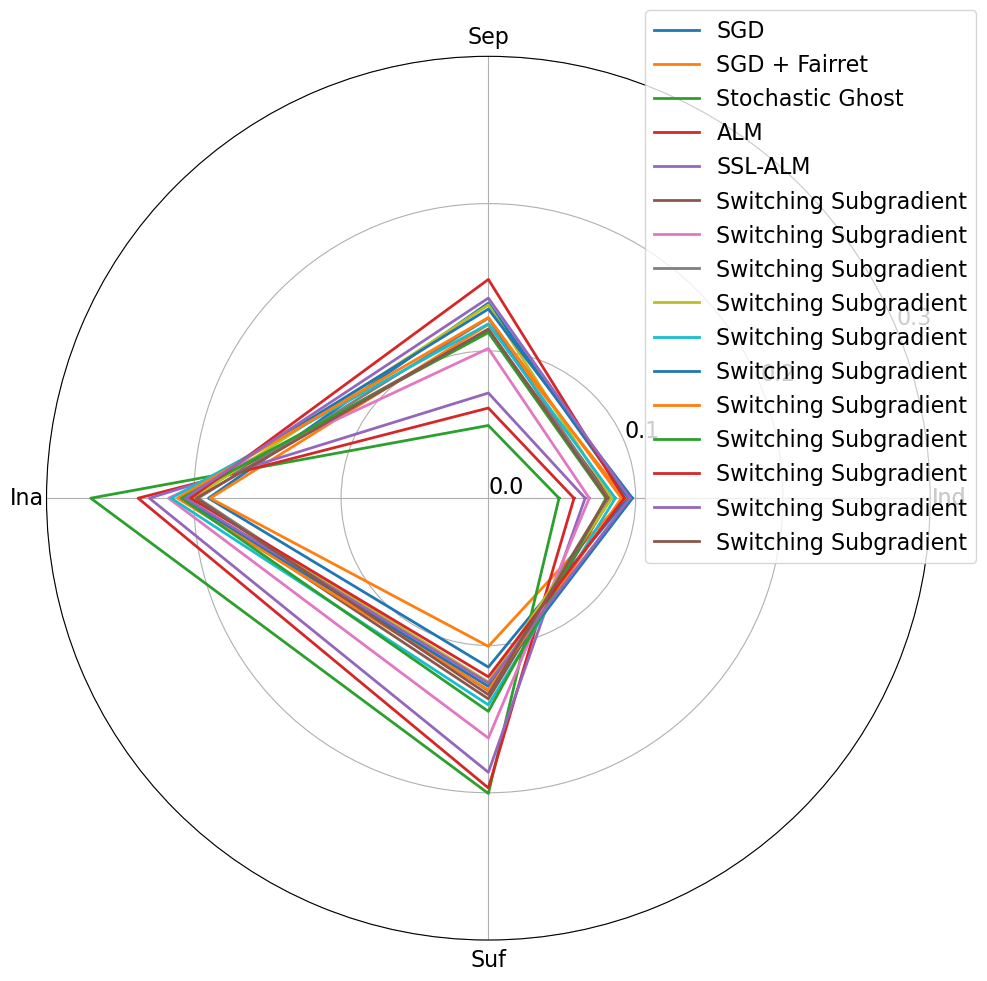

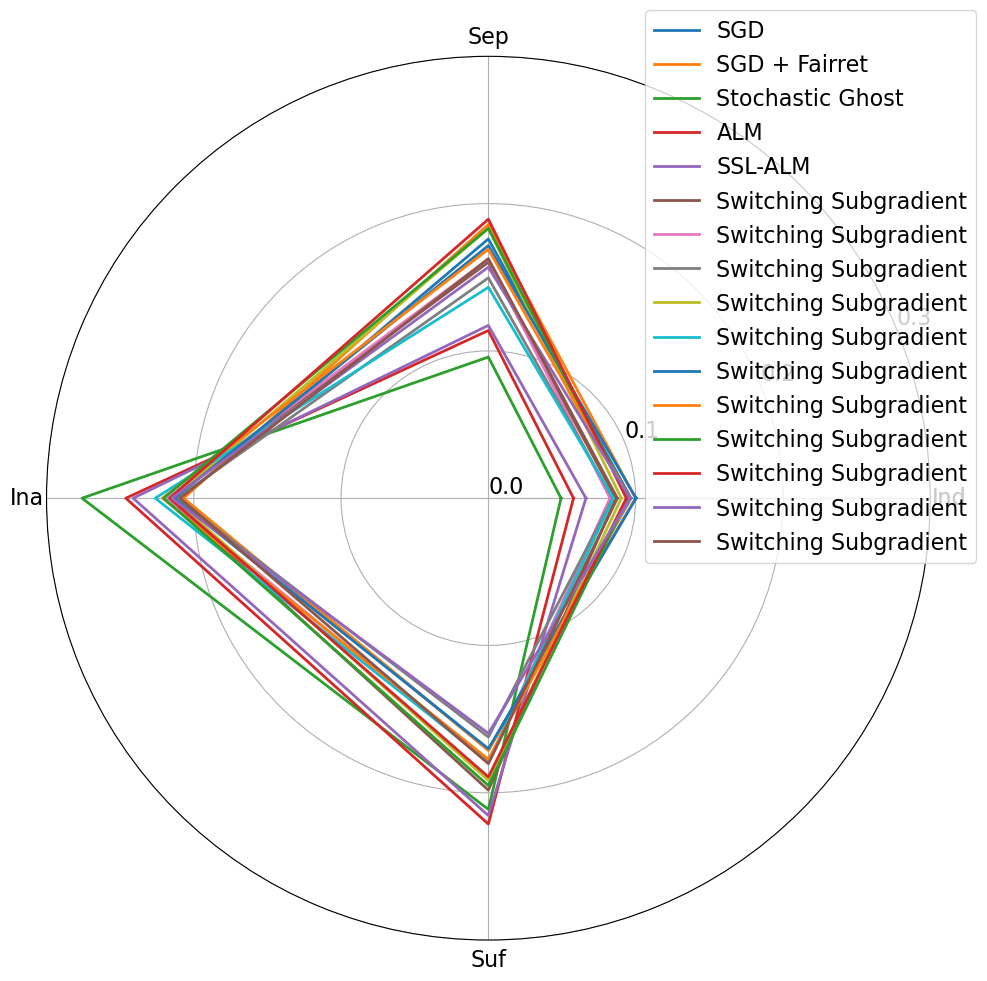

In [17]:
def spider_line(data, title=None):
    plt.rcParams.update({'font.size': 16})
    
    labels = ['Ind', 'Sep', 'Ina', 'Suf']
    # Number of variables we're plotting.
    num_vars = len(labels)

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    angles += angles[:1]
    labels += labels[:1]

    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))

    for alg in data.index:
        values = data.loc[alg, ['Ind', 'Sp', 'Ina','Sf', 'Ind']].tolist()
        ax.plot(angles, values, lw=2, label=get_alg_name(alg))
        # ax.plot(angles, values, lw=2, label=alg)
        ax.set_yticks([0,0.1,0.2, 0.3])

    plt.thetagrids(np.degrees(angles), labels=labels)
    if title:
        ax.set_title(title)
    fig.legend()
    fig.tight_layout()
    return fig

f = spider_line(train_df)
f = spider_line(test_df)


**Optimal thresholds:**

In [18]:
results_list_nr = []

with torch.inference_mode():
    for model_index, model_iter in enumerate(loaded_models):
        # Set the model to evaluation mode
        (model_name, model) = model_iter
        model.eval()

        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)

        # Calculate AUCs for sensitive attribute 0 
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_test_w, predictions_0)
        auc_0 = auc(1-fpr_0, 1-tpr_0)  # AUC for FNR is calculated using TPR as x-axis and 1-FPR as y-axis
        tnr_minus_fnr_0 = (1-fpr_0) - (1-tpr_0)
        # Find the threshold that maximizes TPR - FPR difference
        optimal_threshold_index_0 = np.argmax(tnr_minus_fnr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate AUCs for sensitive attribute 1 
        fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_nw, predictions_1)
        auc_1 = auc(1-fpr_1, 1-tpr_1)  # AUC for TNR is calculated using 1-FPR as x-axis and TPR as y-axis
        tnr_minus_fnr_1 = (1-fpr_1) - (1-tpr_1)
        # Find the threshold that maximizes TPR - FPR difference
        optimal_threshold_index_1 = np.argmax(tnr_minus_fnr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]
        
        auc_hm = (auc_0*auc_1)/(auc_0+auc_1)
        results_list_nr.append({'Model': str(model_name),
                                            'AUC_Sensitive_0': auc_0,
                                            'AUC_Sensitive_1': auc_1,
                                            'Optimal_Threshold_0': optimal_threshold_0,
                                            'Optimal_Threshold_1': optimal_threshold_1,
                                            'AUC_HM': auc_hm
                                            })
        
    results_df_nr = pd.DataFrame(results_list_nr)

**Distribution of predictions by group:**

In [22]:
predictions_0 = {}
predictions_1 = {}

for model_name, model in loaded_models:
    preds_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    preds_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()
    try:
        predictions_0[model_name].append(preds_0)
        predictions_1[model_name].append(preds_1)
    except:
        predictions_0[model_name] = [preds_0]
        predictions_1[model_name] = [preds_1]

for name in np.unique([name for name, _ in loaded_models]):
    predictions_0[name] = np.concatenate(predictions_0[name])
    predictions_1[name] = np.concatenate(predictions_1[name])

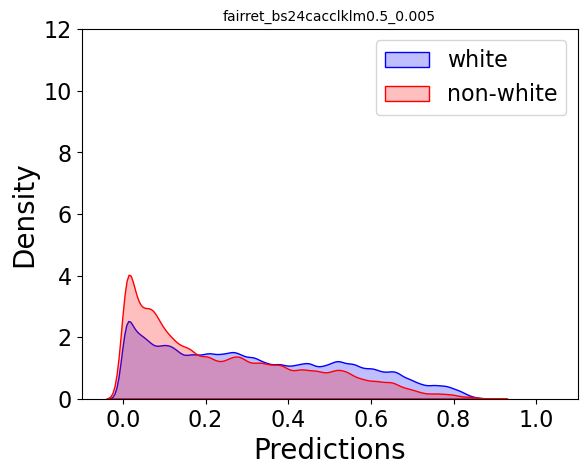

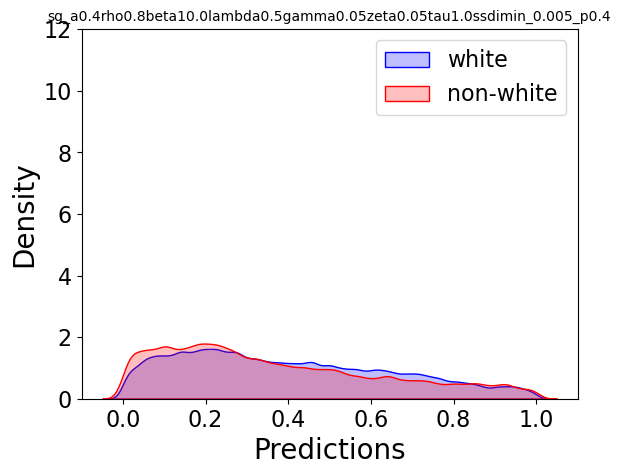

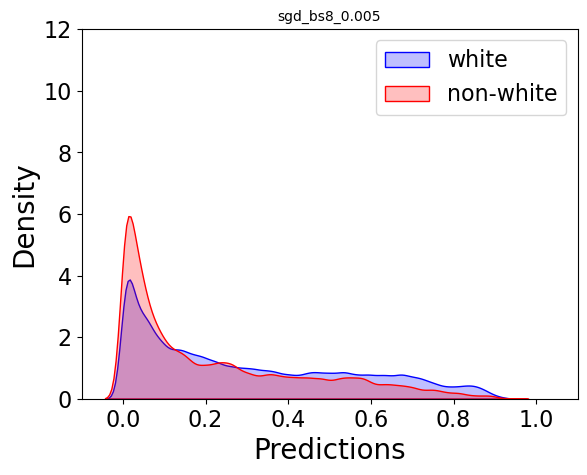

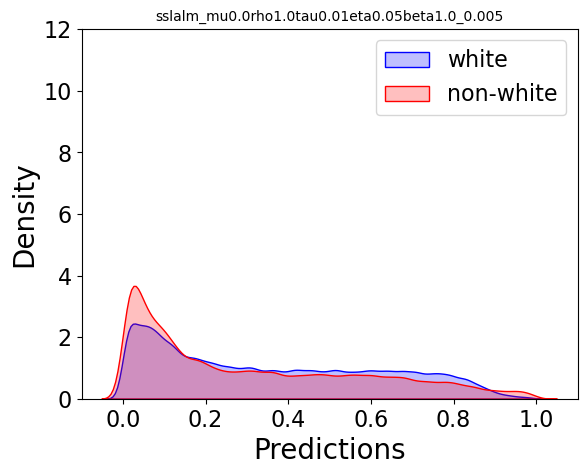

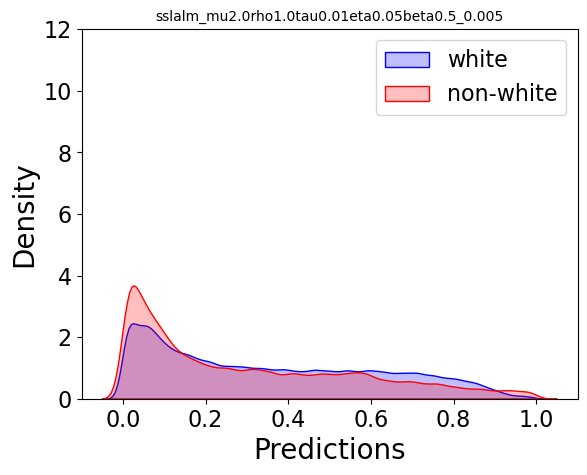

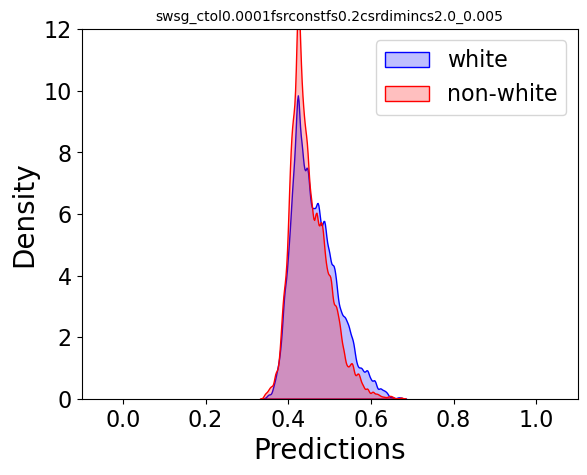

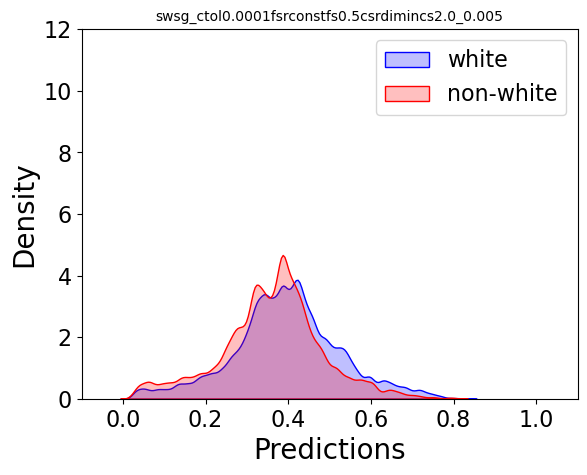

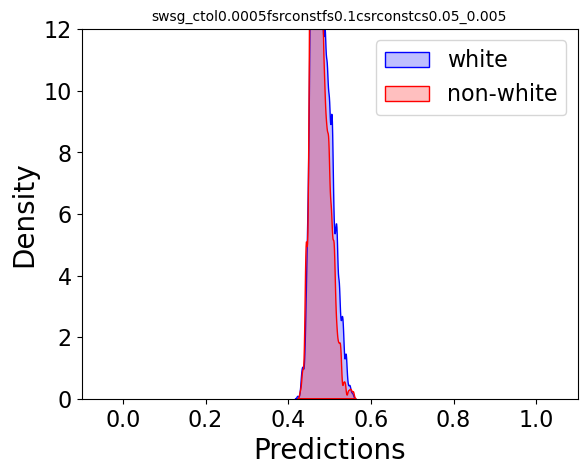

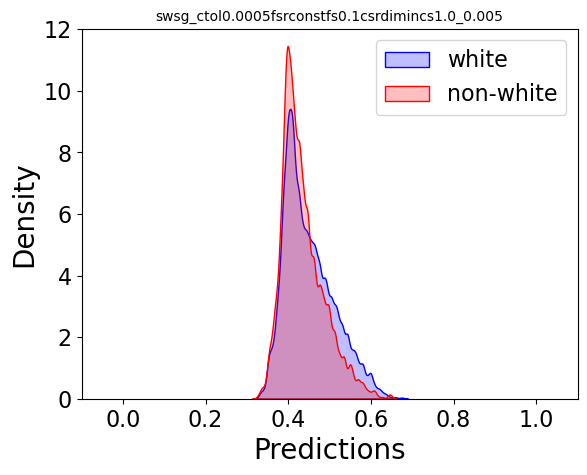

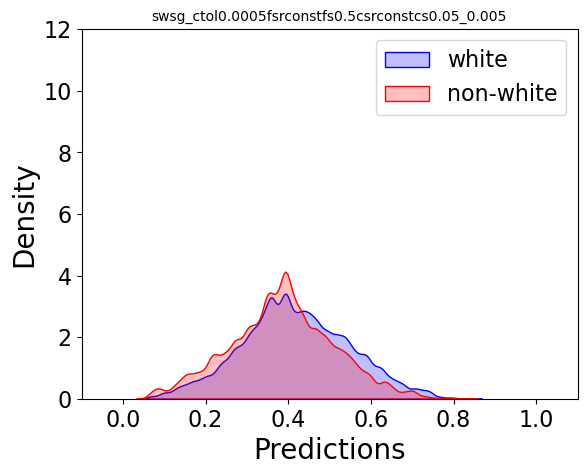

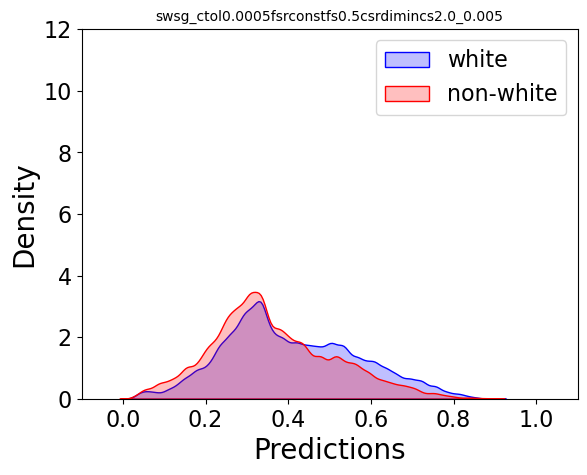

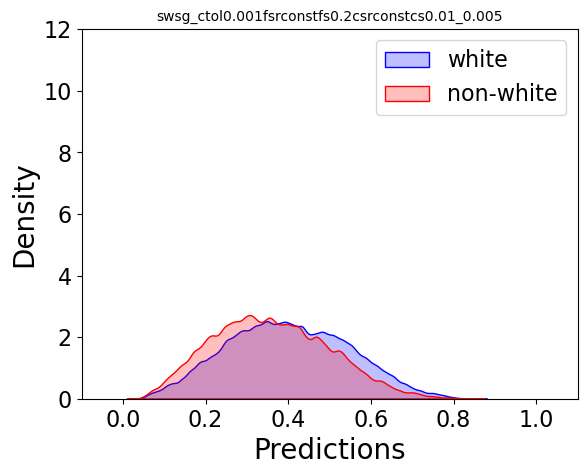

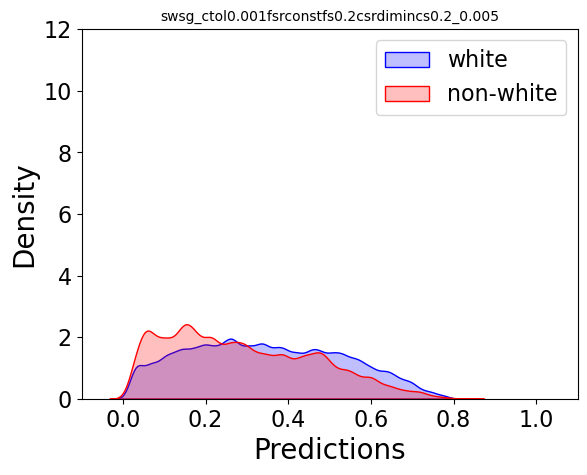

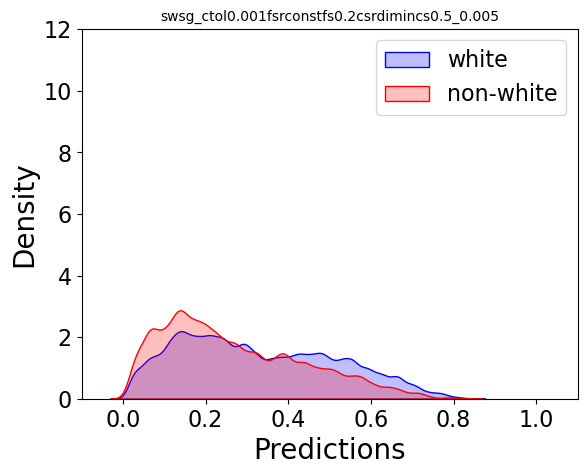

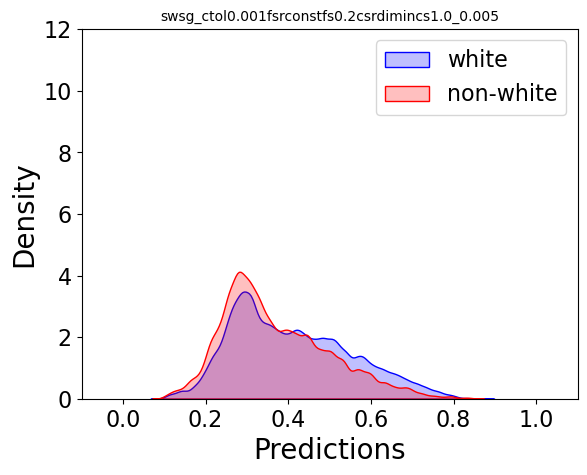

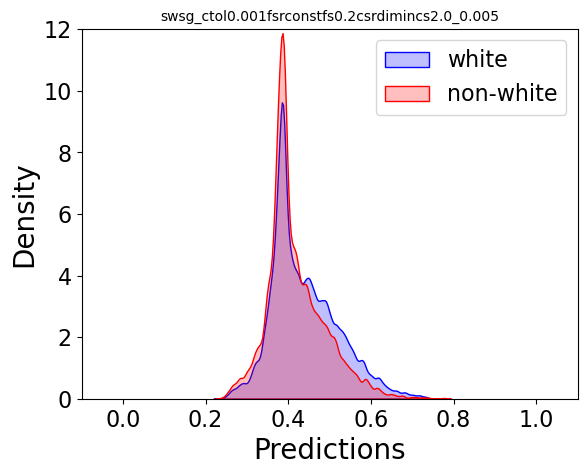

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

for model_name in np.unique([name for name, _ in loaded_models]):

    # predictions_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    # predictions_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()
    
    sns.kdeplot(predictions_0[model_name].squeeze(), label=sensitive_value_0, color='blue', fill=True,bw_adjust=.4)
    sns.kdeplot(predictions_1[model_name].squeeze(), label=sensitive_value_1, color='red', fill=True,bw_adjust=.4)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0,12)
    plt.xlabel('Predictions', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.title(model_name, fontsize=10)
    # plt.title(alg)
    # print(alg)
    alg_name = 'sslalm_aug' if model_name.startswith('sslalm_mu0') else model_name.split('_')[0]
    plt.savefig(f'./plots/{alg_name}/{DATASET}/dist')
    plt.legend()
    plt.show()

### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [429]:
select_by = 'auc'

In [430]:
best_models = {}
algs = res_df_test.Algorithm.unique()
for alg in algs:
    alg_df = res_df_test[res_df_test.Algorithm == alg]
    if select_by == 'auc':
        model = loaded_models[alg_df.AUC_M.idxmax()]
    elif select_by == 'wd':
        model = loaded_models[alg_df.Wd.idxmin()]
    best_models[alg] = model

In [431]:
from fairret.statistic import TruePositiveRate

statistic = Accuracy()

for alg in algs:
    model = best_models[alg][1]
    preds = torch.concat([model(X_test_w), model(X_test_nw)])
    pred = torch.sigmoid(preds)
    sens = torch.concat([torch.tensor([[1.,0.]]*len(X_test_w)), torch.tensor([[0.,1.]]*len(X_test_nw))])
    label = torch.concat([y_test_w, y_test_nw])

    stat_per_group = statistic(pred, sens, label.unsqueeze(1))
    absolute_diff = torch.abs(stat_per_group[0] - stat_per_group[1])
    print(alg)
    print(stat_per_group)
    print(absolute_diff)

fairret_bs24cacclklm0.5_0.005
tensor([0.6904, 0.7308], grad_fn=<IndexPutBackward0>)
tensor(0.0404, grad_fn=<AbsBackward0>)
sgd_bs8_0.005
tensor([0.7117, 0.7526], grad_fn=<IndexPutBackward0>)
tensor(0.0408, grad_fn=<AbsBackward0>)
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05tau1.0ssdimin_0.005_p0.4
tensor([0.6694, 0.6932], grad_fn=<IndexPutBackward0>)
tensor(0.0238, grad_fn=<AbsBackward0>)
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005
tensor([0.6910, 0.7221], grad_fn=<IndexPutBackward0>)
tensor(0.0311, grad_fn=<AbsBackward0>)
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005
tensor([0.6915, 0.7325], grad_fn=<IndexPutBackward0>)
tensor(0.0410, grad_fn=<AbsBackward0>)
swsg_ctol0.001fsrconstfs0.2csrconstcs0.01_0.005
tensor([0.5904, 0.6104], grad_fn=<IndexPutBackward0>)
tensor(0.0200, grad_fn=<AbsBackward0>)


#### Subgroup ROC

In [432]:
# from abroca import compute_abroca

# alg_dfs = []
# for alg in algs:
#     preds = np.concatenate([best_models[alg][1](X_test_w).detach().numpy(), best_models[alg][1](X_test_nw).detach().numpy()])
#     alg_dfs.append(pd.DataFrame({'preds': preds.T[0], 'label': np.concatenate([y_test_w, y_test_nw]), 'race': np.concatenate([[0]*len(X_test_w), [1]*len(X_test_nw)])}))

In [433]:
# slice = compute_abroca(alg_dfs[0], pred_col = 'preds' , label_col = 'label',         
#                        protected_attr_col = 'race', compare_type = 'binary', majority_protected_attr_val=0,
#                        n_grid = 10000, plot_slices = True)

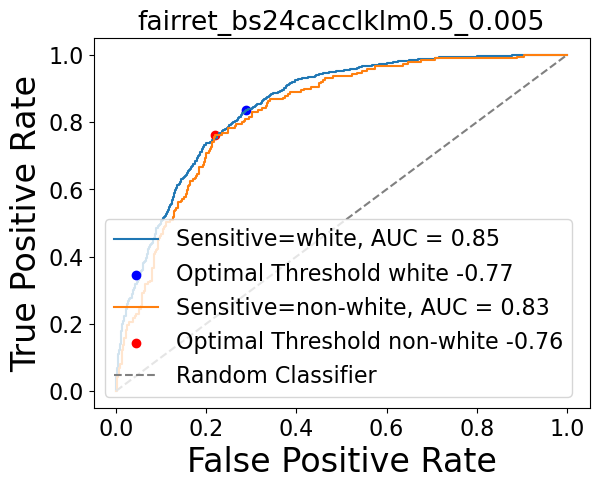

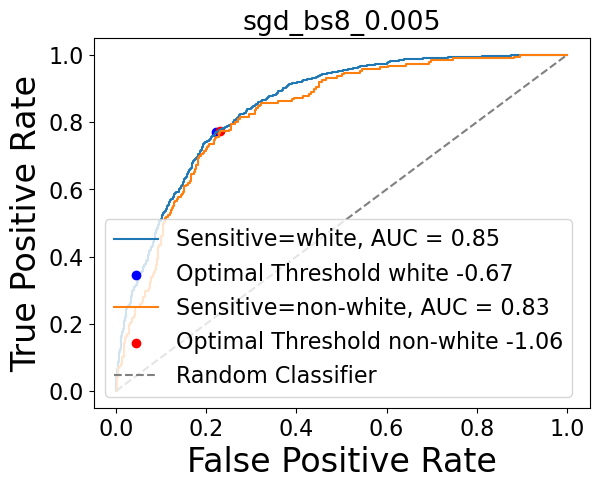

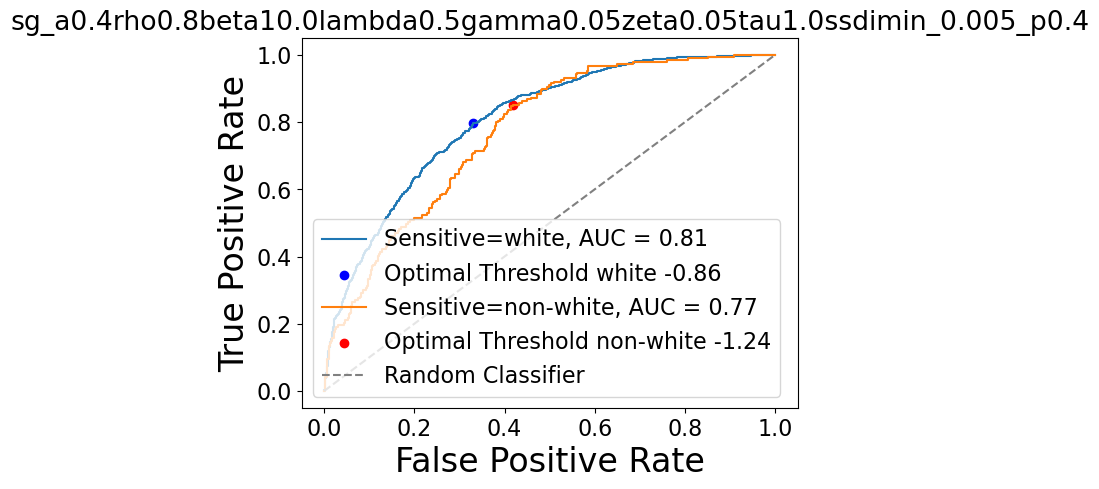

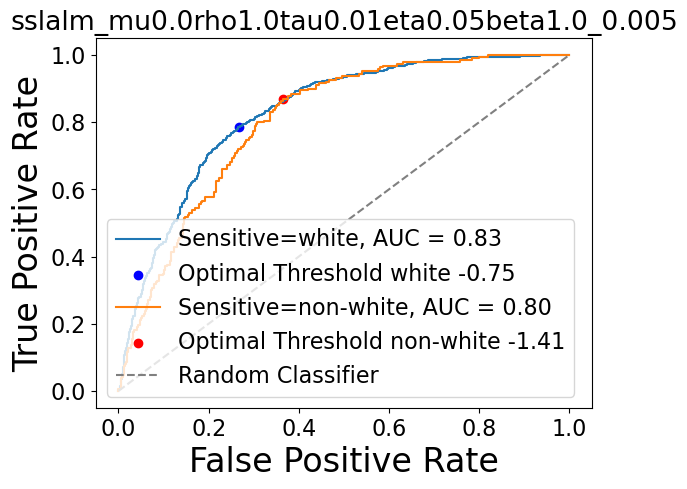

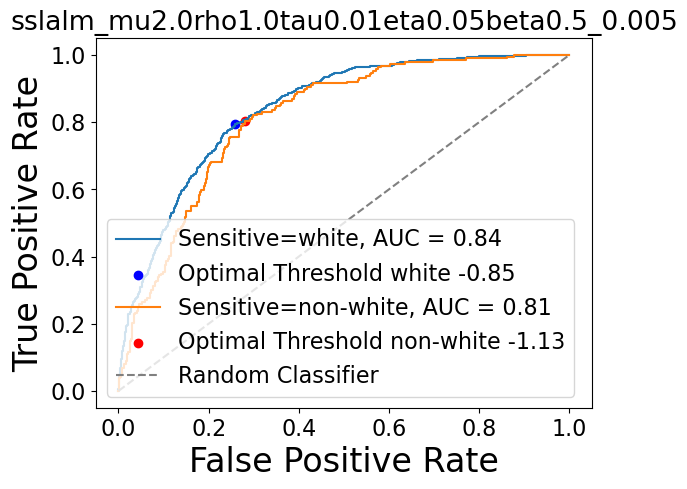

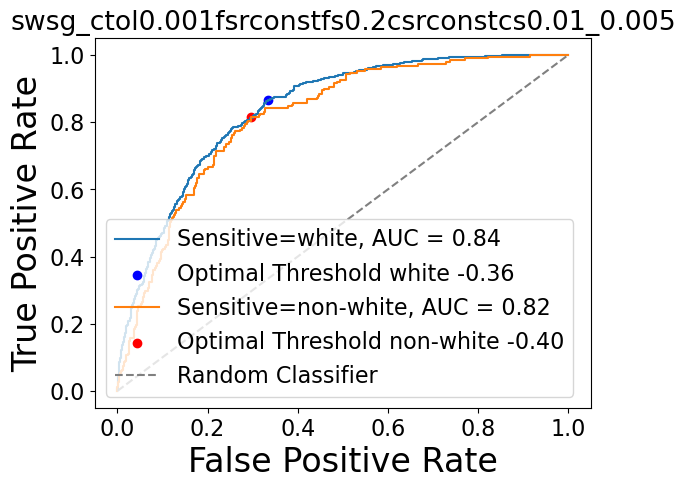

In [434]:
from sklearn.metrics import roc_curve, auc

# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index],
                c='blue' if sensitive_value == sensitive_value_0 else 'red',
                label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    
for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax  =  f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_pr(ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0)
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_pr(ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        ax.set_xlabel('False Positive Rate', fontsize=24)
        ax.set_ylabel('True Positive Rate', fontsize=24)
        ax.legend()

**TNR-FNR plot**

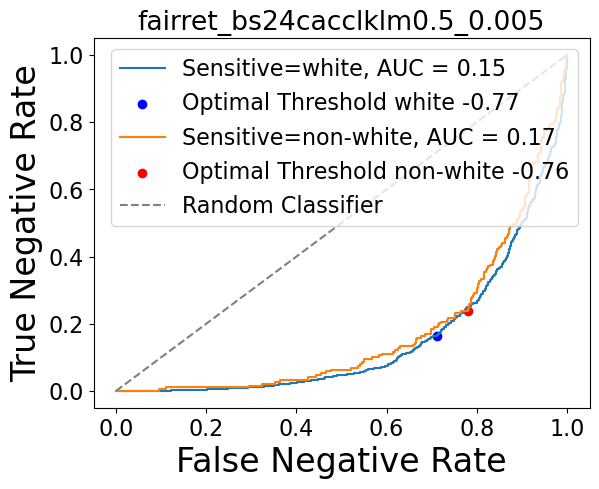

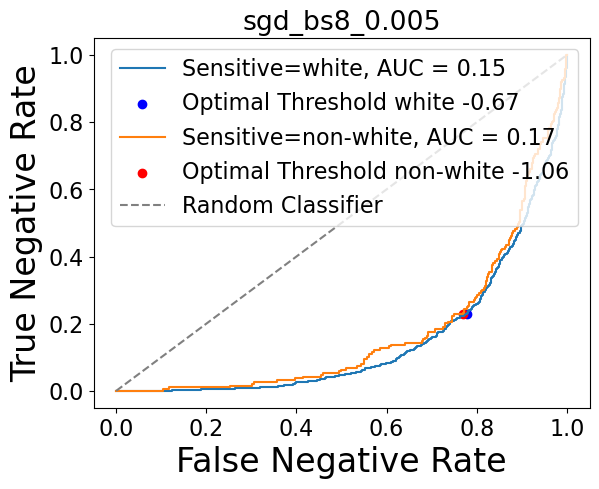

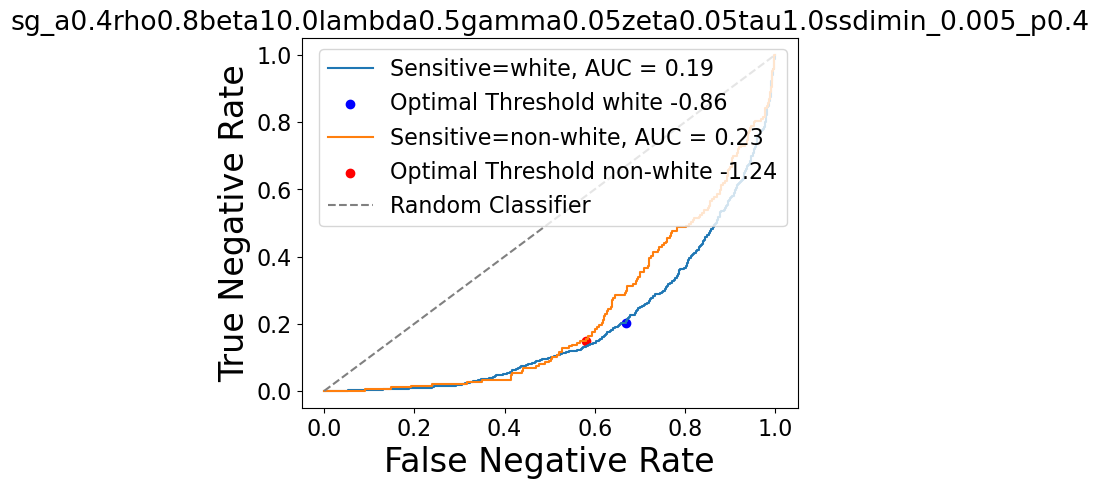

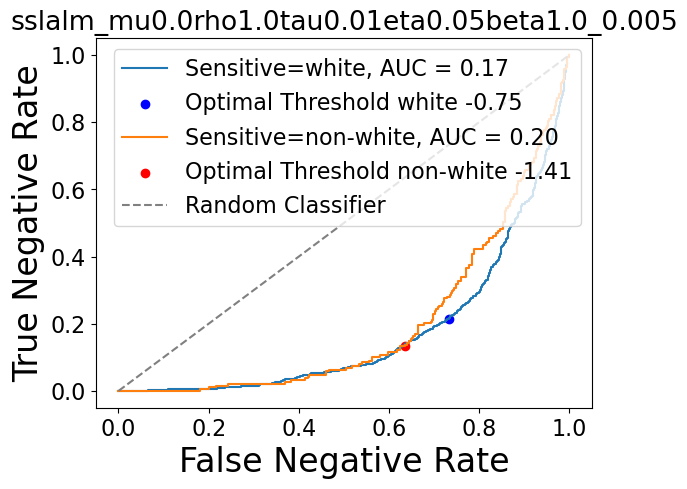

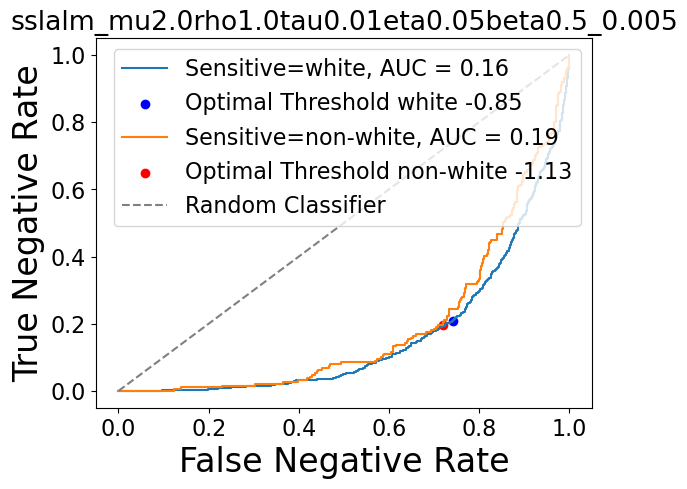

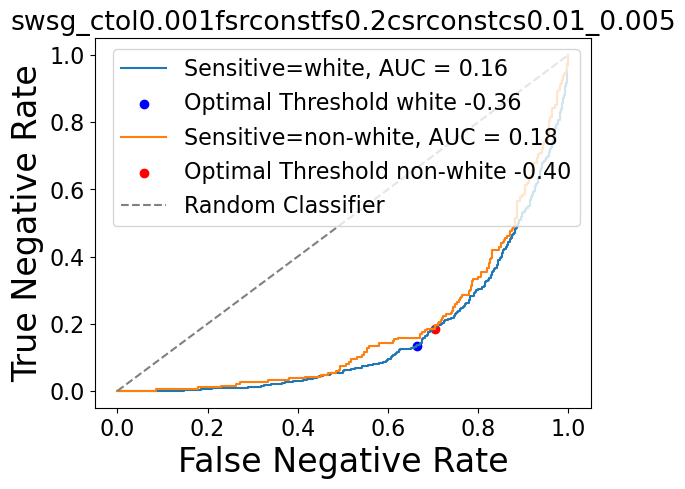

In [435]:
from sklearn.metrics import roc_curve, auc

# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = (1-tpr)
    tnr = (1-fpr)
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(tnr[optimal_threshold_index],fnr[optimal_threshold_index],
                c='blue' if sensitive_value == sensitive_value_0 else 'red',
                label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    
for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax  =  f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_nr(ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0)
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_nr(ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        ax.set_xlabel('False Negative Rate', fontsize=24)
        ax.set_ylabel('True Negative Rate', fontsize=24)
        ax.legend()

In [438]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pandas as pd

# Define function to calculate metrics based on threshold
def calculate_metrics(threshold):
    #acc_values = []

    # Calculate predictions for both sensitive values
    predictions_0_tensor = model(X_test_w)
    predictions_1_tensor = model(X_test_nw)
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    
    outputs = model.evaluate(model.to_backend(x_scaled))
    predictions = (outputs >= threshold)

    true = y

    df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
    df_out["pred_labels"] = np.array(predictions).astype(int)
    df_out["true_labels"] = np.array(true).astype(int)

    acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]]) / len(df_out)
    #acc_values.append(acc)

    # True Positives, False Positives, True Negatives, False Negatives
    # True Positives, False Positives, True Negatives, False Negatives
    tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

    tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

    # Additional calculations
    fpr_sensitive_1 = fp_sensitive_1 / (fp_sensitive_1 + tn_sensitive_1) 
    tpr_sensitive_1 = tp_sensitive_1 / (tp_sensitive_1 + fn_sensitive_1) 
    fpr_sensitive_0 = fp_sensitive_0 / (fp_sensitive_0 + tn_sensitive_0) 
    tpr_sensitive_0 = tp_sensitive_0 / (tp_sensitive_0 + fn_sensitive_0) 

    fnr_sensitive_1 = fn_sensitive_1 / (fn_sensitive_1 + tp_sensitive_1) 
    tnr_sensitive_1 = tn_sensitive_1 / (tn_sensitive_1 + fp_sensitive_1)
    fnr_sensitive_0 = fn_sensitive_0 / (fn_sensitive_0 + tp_sensitive_0) 
    tnr_sensitive_0 = tn_sensitive_0 / (tn_sensitive_0 + fp_sensitive_0)

    ppr_sensitive_0 = (tp_sensitive_0 + fp_sensitive_0) / len(df_out)
    ppr_sensitive_1 = (tp_sensitive_1 + fp_sensitive_1) / len(df_out)

    neg_precision_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fn_sensitive_0)
    neg_precision_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fn_sensitive_1)
    precision_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fp_sensitive_0)
    precision_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fp_sensitive_1)

    return {
        'tpr_'+str(sensitive_value_1): tpr_sensitive_1,
        'fpr_'+str(sensitive_value_1): fpr_sensitive_1,
        'tpr_'+str(sensitive_value_0): tpr_sensitive_0,
        'fpr_'+str(sensitive_value_0): fpr_sensitive_0,
        'fnr_'+str(sensitive_value_1): fnr_sensitive_1,
        'tnr_'+str(sensitive_value_1): tnr_sensitive_1,
        'fnr_'+str(sensitive_value_0): fnr_sensitive_0,
        'tnr_'+str(sensitive_value_0): tnr_sensitive_0,
        'ppr_'+str(sensitive_value_0): ppr_sensitive_0,
        'ppr_'+str(sensitive_value_1): ppr_sensitive_1,
        'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0,
        'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1,
        'precision_'+str(sensitive_value_0): precision_sensitive_0,
        'precision_'+str(sensitive_value_1): precision_sensitive_1,
        'acc': acc
    }

# Define function to calculate predictions and update plot based on threshold
def calculate_predictions(threshold):
    # Calculate predictions for both sensitive values
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    predictions_0_tensor = model(X_test_w)
    predictions_1_tensor = model(X_test_nw)
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    # Create density distribution plot
    sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True, ax = ax[0])
    sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True, ax = ax[0])

    # Add labels and title
    ax[0].set_xlabel('Predictions')
    ax[0].set_ylabel('Density')
    ax[0].set_title('Density Distribution conditioned on Sensitive attribute')
    ax[0].axvline(x=threshold, color='green', linestyle='--', label='Threshold')
    ax[0].legend()

    metrics = calculate_metrics(threshold)

    categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
    values3 = [metrics['tpr_'+str(sensitive_value_0)], metrics['fpr_'+str(sensitive_value_0)], 
               metrics['tnr_'+str(sensitive_value_0)], metrics['fnr_'+str(sensitive_value_0)]]
    values4 = [metrics['tpr_'+str(sensitive_value_1)], metrics['fpr_'+str(sensitive_value_1)], 
               metrics['tnr_'+str(sensitive_value_1)], metrics['fnr_'+str(sensitive_value_1)]]
    bar_width = 0.3
    index = np.arange(len(categories2))

    ax[1].bar(index, values3, color='blue', width=bar_width, label='S='+str(sensitive_value_0), alpha=0.5)
    ax[1].bar(index + bar_width, values4, color='red', width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)
    ax[1].set_xticks(index + bar_width / 2)
    ax[1].set_xticklabels(categories2)
    ax[1].set_ylabel("Fraction")
    ax[1].legend()
    ax[1].set_title("Performance metrics over dataset")

    # Show legend
    

    # Show plot
    plt.show()

    # Calculate and display metrics
    
    f1_sens_0 = 2*(metrics['tpr_'+str(sensitive_value_0)]*metrics['precision_'+str(sensitive_value_0)])/(metrics['tpr_'+str(sensitive_value_0)] + metrics['precision_'+str(sensitive_value_0)])
    f1_sens_1 = 2*(metrics['tpr_'+str(sensitive_value_1)]*metrics['precision_'+str(sensitive_value_1)])/(metrics['tpr_'+str(sensitive_value_1)] + metrics['precision_'+str(sensitive_value_1)])
    
    # Calculate and display metrics
    
    print("Accuracy:",metrics['acc'])
    print("precision "+str(sensitive_value_0)+":", metrics['precision_'+str(sensitive_value_0)], "   precision "+str(sensitive_value_1)+":", metrics['precision_'+str(sensitive_value_1)])
    print("recall "+str(sensitive_value_0)+":", metrics['tpr_'+str(sensitive_value_0)], "   recall "+str(sensitive_value_1)+":", metrics['tpr_'+str(sensitive_value_1)])
    print("FPR "+str(sensitive_value_0)+":", metrics['fpr_'+str(sensitive_value_0)], "   FPR "+str(sensitive_value_1)+":", metrics['fpr_'+str(sensitive_value_1)])
    print("F1 "+str(sensitive_value_0)+":", f1_sens_0, "   F1 "+str(sensitive_value_1)+":", f1_sens_1)




The decision threshold range can be usually determined from the ROC curves by analysing the optimal threshold values for sensitive attributes and swiping in a window containing the values. 

In [439]:
#select min and max values to view the metrics

######INCOME#######
#min_thresh = 0.446
#max_thresh = 0.460
######INCOME#######

######COMPAS#######
min_thresh = 0.461
max_thresh = 0.467
######COMPAS#######

steps = int((max_thresh - min_thresh)/50.)
# Create slider for selecting the shift value
shift_slider = FloatSlider(value=min_thresh, min=min_thresh, max=max_thresh, step=steps, description='Decision boundary:', readout_format='.4f')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        calculate_predictions(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox

NameError: name 'FloatSlider' is not defined

Display various metrics for different threshold values in a range

In [ ]:
thresholds = np.linspace(min_thresh, max_thresh, 20)
acc_values = []
fpr_sensitive_1_values = []
tpr_sensitive_1_values = []
fpr_sensitive_0_values = []
tpr_sensitive_0_values = []
fnr_sensitive_1_values = []
tnr_sensitive_1_values = []
fnr_sensitive_0_values = []
tnr_sensitive_0_values = []
ppr_sensitive_0_values = []
ppr_sensitive_1_values = []
neg_precision_sensitive_0_values = []
neg_precision_sensitive_1_values = []
precision_sensitive_0_values = []
precision_sensitive_1_values = []

for thresh in thresholds:
    metrics = calculate_metrics(thresh)

    fpr_sensitive_1_values.append(metrics['fpr_'+str(sensitive_value_1)])
    tpr_sensitive_1_values.append(metrics['tpr_'+str(sensitive_value_1)])
    fpr_sensitive_0_values.append(metrics['fpr_'+str(sensitive_value_0)])
    tpr_sensitive_0_values.append(metrics['tpr_'+str(sensitive_value_0)])

    fnr_sensitive_1_values.append(metrics['fnr_'+str(sensitive_value_1)])
    tnr_sensitive_1_values.append(metrics['tnr_'+str(sensitive_value_1)])
    fnr_sensitive_0_values.append(metrics['fnr_'+str(sensitive_value_0)])
    tnr_sensitive_0_values.append(metrics['tnr_'+str(sensitive_value_0)])

    ppr_sensitive_0_values.append(metrics['ppr_'+str(sensitive_value_0)])
    ppr_sensitive_1_values.append(metrics['ppr_'+str(sensitive_value_1)])

    neg_precision_sensitive_1_values.append(metrics['neg_precision_'+str(sensitive_value_1)])
    neg_precision_sensitive_0_values.append(metrics['neg_precision_'+str(sensitive_value_0)])
    precision_sensitive_1_values.append(metrics['precision_'+str(sensitive_value_1)])
    precision_sensitive_0_values.append(metrics['precision_'+str(sensitive_value_0)])
    acc_values.append(metrics['acc'])



In [ ]:
data = {
    'thresh' : thresholds,
    'acc': acc_values, 
    'fpr_'+str(sensitive_value_1): fpr_sensitive_1_values,
    'tpr_'+str(sensitive_value_1): tpr_sensitive_1_values,
    'fpr_'+str(sensitive_value_0): fpr_sensitive_0_values,
    'tpr_'+str(sensitive_value_0): tpr_sensitive_0_values,
    'fnr_'+str(sensitive_value_1): fnr_sensitive_1_values,
    'tnr_'+str(sensitive_value_1): tnr_sensitive_1_values,
    'fnr_'+str(sensitive_value_0): fnr_sensitive_0_values,
    'tnr_'+str(sensitive_value_0): tnr_sensitive_0_values,
    'ppr_'+str(sensitive_value_0): ppr_sensitive_0_values,
    'ppr_'+str(sensitive_value_1): ppr_sensitive_1_values,
    'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0_values,
    'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1_values,
    'precision_'+str(sensitive_value_0): precision_sensitive_0_values,
    'precision_'+str(sensitive_value_1): precision_sensitive_1_values
}

# Create DataFrame
plot_df = pd.DataFrame(data)

In [ ]:
plot_df.sort_values(by='acc')

In [ ]:
plot_df['net_pres_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['precision_'+str(sensitive_value_0)]
plot_df['net_pres_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['precision_'+str(sensitive_value_1)]

In [ ]:
plot_df['F1_'+str(sensitive_value_0)] = 2*plot_df['precision_'+str(sensitive_value_0)]*plot_df['tpr_'+str(sensitive_value_0)]/(plot_df['precision_'+str(sensitive_value_0)] + plot_df['tpr_'+str(sensitive_value_0)])
plot_df['F1_'+str(sensitive_value_1)] = 2*plot_df['precision_'+str(sensitive_value_1)]*plot_df['tpr_'+str(sensitive_value_1)]/(plot_df['precision_'+str(sensitive_value_1)] + plot_df['tpr_'+str(sensitive_value_1)])

In [ ]:
plot_df['neg_F1_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['tnr_'+str(sensitive_value_0)]/(plot_df['neg_precision_'+str(sensitive_value_0)] + plot_df['tnr_'+str(sensitive_value_0)])
plot_df['neg_F1_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['tnr_'+str(sensitive_value_1)]/(plot_df['neg_precision_'+str(sensitive_value_1)] + plot_df['tnr_'+str(sensitive_value_1)])

In [ ]:
import matplotlib.pyplot as plt

# Your DataFrame plot_df
# Assuming plot_df contains columns: 'thresh', 'acc', 'net_pres_male', 'net_pres_female'

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plotting accuracy on the left y-axis
color = 'green'
ax1.set_xlabel('Threshold', fontsize=24)
ax1.set_ylabel('Accuracy', color=color, fontsize=24)
ax1.plot(plot_df['thresh'], plot_df['acc'], label='Accuracy', color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for precision
ax2 = ax1.twinx()

# Plotting precision on the right y-axis
#color = 'red'
ax2.set_ylabel('F1-score', fontsize=24)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_0)], label='F1 '+str(sensitive_value_0), color='blue', alpha=0.6)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_1)], label='F1 '+str(sensitive_value_1), color='red', alpha=0.6)
ax2.tick_params(axis='y')

# Title and legend
#plt.title('Accuracy and F1-score vs Threshold', fontsize=15)

# Adjusting legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=15)

# Grid
ax1.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [ ]:
#######INCOME########
#threshh = 0.455
#######INCOME########

#######COMPAS########

#######COMPAS########
#(model_name,model) = loaded_models[8]
(model_name,model) = loaded_models[model_idx]

outputs = model.evaluate(model.to_backend(x_scaled))
predictions = (outputs >= 0.456)
true = y

In [ ]:
############  FOR INCOME  #############
df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
df_out["pred_labels"] = np.array(predictions).astype(int)
df_out["true_labels"] = np.array(true).astype(int)

In [ ]:
# ############ FOR COMPAS ############
# df_out = pd.DataFrame(np.array(x_raw), columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid'])
# df_out["pred_labels"] = np.array(predictions).astype(int)
# df_out["true_labels"] = np.array(true).astype(int)

In [ ]:
acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]])/len(df_out)
print(acc)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = [category_0, category_1]
values1 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 1)])]
values2 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
#ax[0].set_title("Distribution of True labels across "+ str(sensitive))
ax[0].legend()


categories2 = [category_0, category_1]
values3 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 1)])]
values4 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
#ax[1].set_title("Distribution of Predicted labels across "+str(sensitive))
ax[1].legend()

In [ ]:
tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

In [ ]:
fpr_sensitive_1 = fp_sensitive_1/(fp_sensitive_1 + tn_sensitive_1)
tpr_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fn_sensitive_1)
fpr_sensitive_0 = fp_sensitive_0/(fp_sensitive_0 + tn_sensitive_0)
tpr_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fn_sensitive_0)

fnr_sensitive_1 = fn_sensitive_1/(fn_sensitive_1 + tp_sensitive_1)
tnr_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fp_sensitive_1)
fnr_sensitive_0 = fn_sensitive_0/(fn_sensitive_0 + tp_sensitive_0)
tnr_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fp_sensitive_0)

Various rates achieved with the particular model selection (values directly taken from a general unconstrained optimizion problem (Adam for ex))

In [ ]:
if DATASET == 'compas':
    values1 = [0.41, 0.15, 0.85, 0.58]
    values2 = [0.64, 0.32, 0.66, 0.34]
elif DATASET == 'income':
    values1 = [0.48, 0.08, 0.65, 0.32]
    values2 = [0.28, 0.01, 0.41, 0.14]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['TPR', 'FPR', 'TNR', 'FNR']
# values1 = [0.41, 0.15, 0.85, 0.58]
# values2 = [0.64, 0.32, 0.66, 0.34]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Fraction", fontsize=24)
#ax[0].set_title('Performance metrics without constraints')
ax[0].legend()


categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
values3 = [tpr_sensitive_0, fpr_sensitive_0, tnr_sensitive_0, fnr_sensitive_0]
values4 = [tpr_sensitive_1, fpr_sensitive_1, tnr_sensitive_1, fnr_sensitive_1]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Fraction", fontsize=24)
#ax[1].set_title('Performance metrics with constraints')
ax[1].legend()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Function to plot y = sin(x - value_slider)
def plot_sin(shift):
    x = np.linspace(0, np.pi * 2, 1000)
    y = np.sin(x - shift)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('sin(x - shift)')
    plt.title('Plot of y = sin(x - shift)')
    plt.grid(True)
    plt.show()

# Create slider for selecting the shift value
shift_slider = FloatSlider(value=0, min=0, max=np.pi/2, step=0.01, description='Shift:')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        plot_sin(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox